# Import Libraries/Packages

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential  
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
import keras.backend as K

from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, Adam

from keras_tuner import HyperModel
from keras_tuner.tuners import GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import tensorflow
tensorflow.config.run_functions_eagerly(True)

# Load Dataset

In [3]:
data_train_temp = np.load('kmnist-train-imgs.npz')
labels_train_temp = np.load('kmnist-train-labels.npz')
data_test_temp = np.load('kmnist-test-imgs.npz')
labels_test_temp = np.load('kmnist-test-labels.npz')

In [4]:
data_train = data_train_temp['arr_0']
labels_train = labels_train_temp['arr_0']
data_test = data_test_temp['arr_0']
labels_test = labels_test_temp['arr_0']

In [5]:
oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oh_encoder.fit(labels_train.reshape(-1,1))
labels_train_hot = oh_encoder.transform(labels_train.reshape(-1,1))
labels_test_hot = oh_encoder.transform(labels_test.reshape(-1,1))

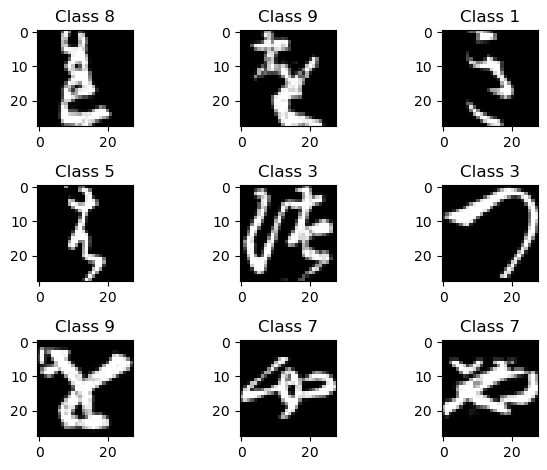

In [6]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(data_train))
    plt.imshow(data_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels_train[num]))
    
plt.tight_layout()

In [7]:
data_train = data_train.reshape(60000, 784) 
data_test = data_test.reshape(10000, 784)   

data_train = data_train.astype('float32')   
data_test = data_test.astype('float32')

data_train /= 255                        
data_test /= 255

#data_train = data_train.reshape((data_train.shape[0], 28, 28, 1))
#data_test = data_test.reshape((data_test.shape[0], 28, 28, 1))

print("Training matrix shape", data_train.shape)
print("Testing matrix shape", data_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


# Part 1

## Section A: Design SAE Network

In [8]:
def build_enc(neck_width):
    enc_model = Sequential()
    enc_model.add(Dense(784,))
    enc_model.add(Dense(800, activation='relu'))
    enc_model.add(Dense(200, activation='relu'))
    enc_model.add(Dense(neck_width, activation='relu'))
    return enc_model

In [9]:
def build_dec(neck_width):
    dec_model = Sequential()
    dec_model.add(Dense(neck_width,))
    dec_model.add(Dense(200, activation='relu'))
    dec_model.add(Dense(800, activation='relu'))
    dec_model.add(Dense(784,))
    return dec_model

In [10]:
def build_sae(hp):
    neck_width = hp.Int('bottle_neck', min_value=50, max_value=100, step=5)
    
    enc_model = build_enc(neck_width)
    dec_model = build_dec(neck_width)
    
    sae_model = Sequential()
    sae_model.add(enc_model)
    sae_model.add(dec_model)
    
    return sae_model

## Section B: Train the SAE Models

### 1) Correntropy Loss Function

In [11]:
def correntropy_loss(sigma):
    def loss(y_true, y_pred):
        kernel = K.exp(-K.square(y_pred - y_true) / (2 * sigma * sigma))
        return -K.mean(kernel)
    return loss

### 2) Create Hypermodels

In [12]:
class SAEHyperModel(HyperModel):
    def build(self, hp):
        model = build_sae(hp)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp_sae.Choice('batch_size', [32, 64, 128, 256]);
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )

In [13]:
class SAECEHyperModel(HyperModel):
    def build(self, hp):
        sigma = hp.Choice('sigma', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
        
        model = build_sae(hp)
        model.compile(optimizer='adam', loss=correntropy_loss(sigma))
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp_sae.Choice('batch_size', [32, 64, 128, 256]);
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )

### 3) Create Hyperparameters and Tuners

In [14]:
hp_sae = HyperParameters()

hp_sae.Int('bottle_neck', min_value=50, max_value=100, step=10);
hp_sae.Choice('batch_size', [32, 64, 128, 256]);

In [15]:
hp_sae_ce = HyperParameters()

hp_sae_ce.Int('bottle_neck', min_value=50, max_value=100, step=10);
hp_sae_ce.Choice('batch_size', [32, 64, 128, 256]);
hp_sae_ce.Choice('sigma', [0.8, 0.9, 1.0]);

In [29]:
sae_tuner = GridSearch(
    SAEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae,
    max_retries_per_trial=20,
    directory='sae_tuner',
    project_name='sae_tuning'
)

Reloading Tuner from sae_tuner\sae_tuning\tuner0.json


In [35]:
sae_ce_tuner = GridSearch(
    SAECEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae_ce,
    max_retries_per_trial=20,
    directory='sae_ce_tuner',
    project_name='sae_ce_tuning'
)

### 4) Search for Optimal Encoder [MSE, No Noise]

In [31]:
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.005)

In [32]:
sae_tuner.search(data_train, data_train, epochs=20, validation_split=0.3, callbacks=[callback])

In [155]:
best_hp_sae = sae_tuner.get_best_hyperparameters()[0]

In [156]:
for hp, value in best_hp_sae.values.items():
    print(f"{hp}: {value}")

bottle_neck: 100
batch_size: 64


In [19]:
best_sae = sae_tuner.get_best_models(num_models=1)[0]

In [20]:
best_sae.fit(data_train, data_train)

1875/1875 [==============================] - 38s 20ms/step - loss: 0.0248


In [21]:
best_encoder = best_sae.layers[0]

In [22]:
bottle_neck_layer = best_encoder.layers[-1]
neck_width = bottle_neck_layer.units

In [26]:
encoded_train_data = best_encoder.predict(data_train)
encoded_test_data = best_encoder.predict(data_test)

313/313 [==============================] - 1s 3ms/step


### 5) Search for Optimal Encoder [CE, No Noise]

In [36]:
sae_ce_tuner.search(data_train, data_train, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 72 Complete [00h 01m 55s]
loss: -0.9864547848701477

Best loss So Far: -0.9869098663330078
Total elapsed time: 02h 18m 02s


In [158]:
best_hp_sae_ce = sae_ce_tuner.get_best_hyperparameters()[0]

In [159]:
for hp, value in best_hp_sae_ce.values.items():
    print(f"{hp}: {value}")

bottle_neck: 100
batch_size: 32
sigma: 1.0


In [37]:
best_sae_ce = sae_ce_tuner.get_best_models(num_models=1)[0]

In [38]:
best_sae_ce.fit(data_train, data_train)

1875/1875 [==============================] - 38s 19ms/step - loss: -0.9876


In [39]:
best_encoder_ce = best_sae_ce.layers[0]

In [40]:
bottle_neck_layer_ce = best_encoder_ce.layers[-1]
neck_width_ce = bottle_neck_layer_ce.units

In [41]:
encoded_train_data_ce = best_encoder_ce.predict(data_train)
encoded_test_data_ce = best_encoder_ce.predict(data_test)

313/313 [==============================] - 1s 3ms/step


## Section C: Design SAE+Classifier

In [26]:
def build_mlp(hp):
    cw = hp_clf.Int('clf_width', min_value=5, max_value=20, step=5)
    ch = hp_clf.Int('clf_height', min_value=1, max_value=3, step=1)
    neck_w = hp_clf.Choice('neck_width', [neck_width])
    
    mlp_model = Sequential()
    mlp_model.add(Dense(neck_w,))
    for i in range(ch):
        mlp_model.add(Dense(cw, activation='relu'))
    mlp_model.add(Dense(10, activation='softmax'))
    
    return mlp_model

## Section D: Train SAE+Classifier

### 1) Create Hypermodels

In [27]:
class CLFHyperModel(HyperModel):
    def build(self, hp):
        model = build_mlp(hp)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp_clf.Choice('batch_size', [32, 64, 128, 256]);
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )

In [44]:
#class CLFCEHyperModel(HyperModel):
#    def build(self, hp):
#        model = build_mlp(hp)
#        model.compile(optimizer='adam', loss='categorical_crossentropy')
#        return model
#    
#    def fit(self, hp, model, *args, **kwargs):
#        batch_size = hp_sae.Choice('batch_size', [32, 64, 128, 256]);
#        return model.fit(
#            *args,
#           batch_size=batch_size,
#            **kwargs
#        )

### 2) Create Hyperparameters and Tuners

In [29]:
hp_clf = HyperParameters()

hp_clf.Int('clf_width', min_value=5, max_value=20, step=5);
hp_clf.Int('clf_height', min_value=1, max_value=3, step=1);
hp_clf.Choice('batch_size', [32,64,128,256]);
hp_clf.Choice('neck_width', [neck_width]);

In [30]:
#hp_clf_ce = HyperParameters()


#hp_clf_ce.Int('clf_width', min_value=5, max_value=20, step=5);
#hp_clf_ce.Int('clf_height', min_value=1, max_value=3, step=1);
#hp_clf_ce.Choice('batch_size', [32,64,128,256]);
#hp_clf_ce.Choice('neck_width', [neck_width]);
#hp_clf_ce.Choice('sigma', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]);

In [31]:
clf_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='clf_tuner',
    project_name='clf_tuning'
)

In [32]:
clf_ce_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='clf_ce_tuner',
    project_name='clf_ce_tuning'
)

### 3) Search for Optimal Classifier [MSE Encoder, No Noise]

In [49]:
clf_tuner.search(encoded_train_data, labels_train_hot, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 48 Complete [00h 00m 06s]
loss: 2.302760124206543

Best loss So Far: 0.8513566851615906
Total elapsed time: 00h 20m 17s


In [160]:
best_hp_clf = clf_tuner.get_best_hyperparameters()[0]

In [161]:
for hp, value in best_hp_clf.values.items():
    print(f"{hp}: {value}")

clf_width: 10
clf_height: 2
batch_size: 128
neck_width: 100


In [50]:
best_clf = clf_tuner.get_best_models()[0]

In [51]:
best_clf.fit(encoded_train_data, labels_train_hot)

1875/1875 [==============================] - 2s 998us/step - loss: 0.8517


### 4) Search for Optimal Classifier [CE Encoder, No Noise]

In [52]:
clf_ce_tuner.search(encoded_train_data_ce, labels_train_hot, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 48 Complete [00h 00m 26s]
loss: 0.8544442653656006

Best loss So Far: 0.843204140663147
Total elapsed time: 00h 22m 51s


In [162]:
best_hp_clf_ce = clf_ce_tuner.get_best_hyperparameters()[0]

In [163]:
for hp, value in best_hp_clf_ce.values.items():
    print(f"{hp}: {value}")

clf_width: 5
clf_height: 1
batch_size: 128
neck_width: 100


In [53]:
best_clf_ce = clf_ce_tuner.get_best_models()[0]

In [54]:
best_clf_ce.fit(encoded_train_data_ce, labels_train_hot)

1875/1875 [==============================] - 2s 949us/step - loss: 0.8415


## Section E: Inject Noise

### 1) Create Noise Function and Add Noise

In [55]:
def add_noise(X, noise_level=0.10):
    """
    Add salt and pepper noise to a NumPy array.

    Parameters:
    - X: NumPy array (image or any numerical array)
    - noise_level: Proportion of elements to be altered. Default is 0.05 (5%)
    
    Returns:
    - Noisy array
    """

    # Copy the input array to avoid overwriting the original data
    X_noisy = np.copy(X)

    # Calculate the number of elements to be affected by noise
    num_noise = int(noise_level * X.size)

    # Choose random locations to place the salt and pepper noise
    coords = [np.random.randint(0, i - 1, num_noise) for i in X.shape]

    # Add salt noise (maximum value)
    X_noisy[tuple(coords)] = np.max(X)

    # Choose random locations for pepper noise
    coords = [np.random.randint(0, i - 1, num_noise) for i in X.shape]

    # Add pepper noise (minimum value)
    X_noisy[tuple(coords)] = np.min(X)

    return X_noisy

# Example usage
# Assuming 'array' is your numpy array:
# noisy_array = add_salt_and_pepper_noise(array, noise_level=0.05)

In [56]:
noisy_train_data = add_noise(data_train, 0.10)
noisy_test_data = add_noise(data_test, 0.10)

noisy_train_data = noisy_train_data.reshape(noisy_train_data.shape[0], 784)
noisy_test_data = noisy_test_data.reshape(noisy_test_data.shape[0], 784)

data_train = data_train.reshape(data_train.shape[0], 784)
data_test = data_test.reshape(data_test.shape[0], 784)

noisy_train_data = noisy_train_data.astype('float32')
noisy_test_data = noisy_test_data.astype('float32')

### 2) Create New Tuners

In [57]:
noisy_sae_tuner = GridSearch(
    SAEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae,
    max_retries_per_trial=20,
    directory='noisy_sae_tuner',
    project_name='noisy_sae_ce_tuning'
)

In [58]:
noisy_sae_ce_tuner = GridSearch(
    SAECEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae_ce,
    max_retries_per_trial=20,
    directory='noisy_sae_ce_tuner',
    project_name='noisy_sae_ce_tuning'
)

In [59]:
noisy_clf_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='noisy_clf_tuner',
    project_name='noisy_clf_tuning'
)

In [60]:
noisy_clf_ce_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='noisy_clf_ce_tuner',
    project_name='noisy_clf_ce_tuning'
)

### 3) Search for Optimal Encoder [MSE, Noise]

In [61]:
noisy_sae_tuner.search(noisy_train_data, data_train, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 24 Complete [00h 02m 52s]
loss: 0.03518451377749443

Best loss So Far: 0.034405723214149475
Total elapsed time: 00h 55m 52s


In [167]:
best_hp_noisy_sae = noisy_sae_tuner.get_best_hyperparameters()[0]

In [168]:
for hp, value in best_hp_noisy_sae.values.items():
    print(f"{hp}: {value}")

bottle_neck: 100
batch_size: 128


In [62]:
best_noisy_sae = noisy_sae_tuner.get_best_models()[0]

In [63]:
best_noisy_sae.fit(noisy_train_data, data_train)

1875/1875 [==============================] - 39s 20ms/step - loss: 0.0339


In [64]:
best_noisy_encoder = best_noisy_sae.layers[0]

In [65]:
noisy_bottle_neck_layer = best_noisy_encoder.layers[-1]
noisy_neck_width = noisy_bottle_neck_layer.units

In [66]:
noisy_encoded_train_data = best_noisy_encoder.predict(data_train)
noisy_encoded_test_data = best_noisy_encoder.predict(data_test)

313/313 [==============================] - 1s 3ms/step


### 4) Search for Optimal Encoder [CE, Noise]

In [67]:
noisy_sae_ce_tuner.search(noisy_train_data, data_train, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 72 Complete [00h 01m 55s]
loss: -0.9822160601615906

Best loss So Far: -0.9825714230537415
Total elapsed time: 02h 17m 32s


In [170]:
best_hp_noisy_sae_ce = noisy_sae_ce_tuner.get_best_hyperparameters()[0]

In [171]:
for hp, value in best_hp_noisy_sae_ce.values.items():
    print(f"{hp}: {value}")

bottle_neck: 100
batch_size: 128
sigma: 1.0


In [68]:
best_noisy_sae_ce = noisy_sae_ce_tuner.get_best_models()[0]

In [69]:
best_noisy_sae_ce.fit(noisy_train_data, data_train)

1875/1875 [==============================] - 38s 20ms/step - loss: -0.9832


In [70]:
best_noisy_encoder_ce = best_noisy_sae_ce.layers[0]

In [71]:
noisy_bottle_neck_layer_ce = best_noisy_encoder_ce.layers[-1]
noisy_neck_width_ce = noisy_bottle_neck_layer_ce.units

In [72]:
noisy_encoded_train_data_ce = best_noisy_encoder_ce.predict(data_train)
noisy_encoded_test_data_ce = best_noisy_encoder_ce.predict(data_test)

313/313 [==============================] - 1s 3ms/step


### 5) Search for Optimal Classifier [MSE Encoder, Noise]

In [73]:
noisy_clf_tuner.search(noisy_encoded_train_data, labels_train_hot, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 48 Complete [00h 00m 24s]
loss: 0.8641530871391296

Best loss So Far: 0.8177862763404846
Total elapsed time: 00h 24m 29s


In [172]:
best_hp_noisy_clf = noisy_clf_tuner.get_best_hyperparameters()[0]

In [173]:
for hp, value in best_hp_noisy_clf.values.items():
    print(f"{hp}: {value}")

clf_width: 10
clf_height: 3
batch_size: 64
neck_width: 100


In [74]:
best_noisy_clf = noisy_clf_tuner.get_best_models()[0]

In [75]:
best_noisy_clf.fit(noisy_encoded_train_data, labels_train_hot)

1875/1875 [==============================] - 2s 992us/step - loss: 0.8160


### 6) Search for Optimal Classifier [CE Encoder, Noise]

In [76]:
noisy_clf_ce_tuner.search(noisy_encoded_train_data_ce, labels_train_hot, epochs=20, validation_split=0.3, callbacks=[callback])

Trial 48 Complete [00h 00m 30s]
loss: 0.8879886269569397

Best loss So Far: 0.8266705870628357
Total elapsed time: 00h 22m 57s


In [175]:
best_hp_noisy_clf_ce = noisy_clf_ce_tuner.get_best_hyperparameters()[0]

In [176]:
for hp, value in best_hp_noisy_clf_ce.values.items():
    print(f"{hp}: {value}")

clf_width: 15
clf_height: 1
batch_size: 64
neck_width: 100


In [77]:
best_noisy_clf_ce = noisy_clf_ce_tuner.get_best_models()[0]

In [109]:
best_noisy_clf_ce.fit(noisy_encoded_train_data_ce, labels_train_hot)

1875/1875 [==============================] - 2s 897us/step - loss: 0.8233


## Section F: Results

### 1) Comparing Bottle Neck Sizes

313/313 [==============================] - 1s 1ms/step
Bottle Neck Width: 50
Accuracy Score: 0.6581
Precision Score: 0.682257450230743
Recall Score: 0.6581
F1 Score: 0.6593931881911167


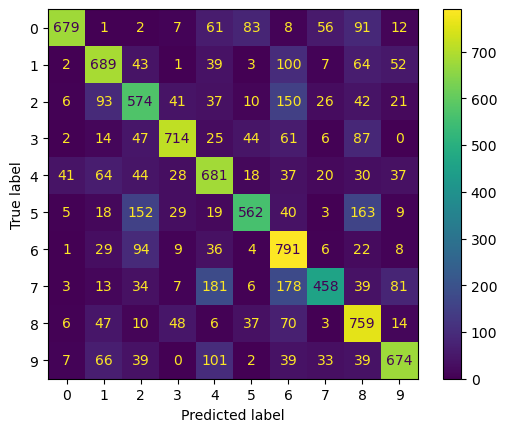

313/313 [==============================] - 0s 1ms/step
Bottle Neck Width: 60
Accuracy Score: 0.624
Precision Score: 0.6547446040084269
Recall Score: 0.6239999999999999
F1 Score: 0.6256302469350375


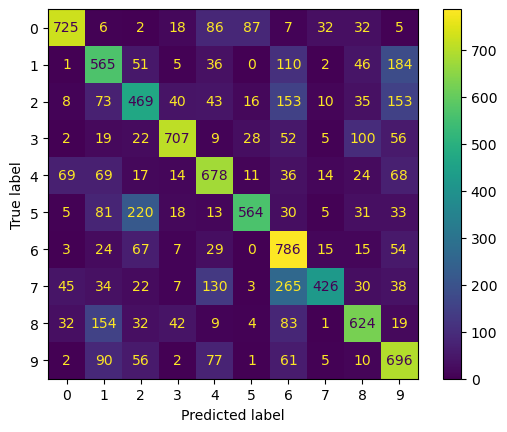

313/313 [==============================] - 0s 1ms/step
Bottle Neck Width: 70
Accuracy Score: 0.6338
Precision Score: 0.6688905774322922
Recall Score: 0.6338000000000001
F1 Score: 0.6375651219161556


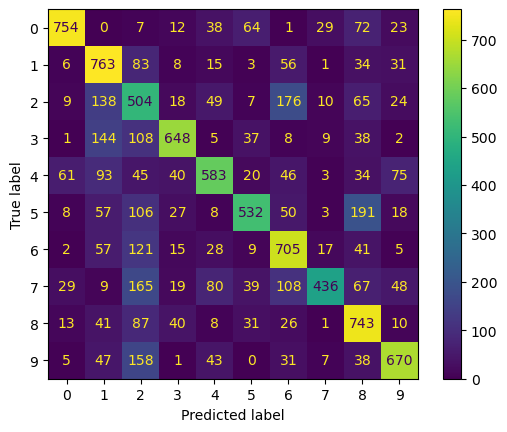

313/313 [==============================] - 1s 2ms/step
Bottle Neck Width: 80
Accuracy Score: 0.6079
Precision Score: 0.6345943169478858
Recall Score: 0.6079000000000001
F1 Score: 0.6118057951118392


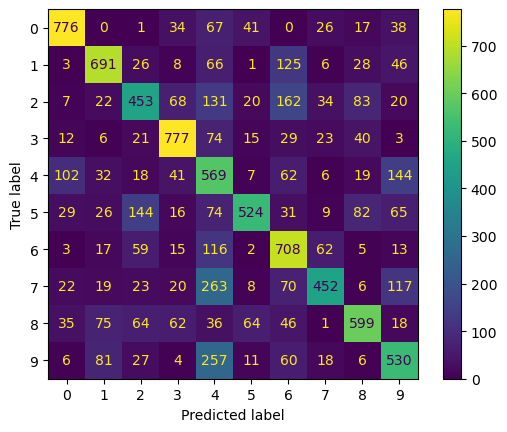

313/313 [==============================] - 1s 2ms/step
Bottle Neck Width: 90
Accuracy Score: 0.6577
Precision Score: 0.672150172941412
Recall Score: 0.6577
F1 Score: 0.6597324954752032


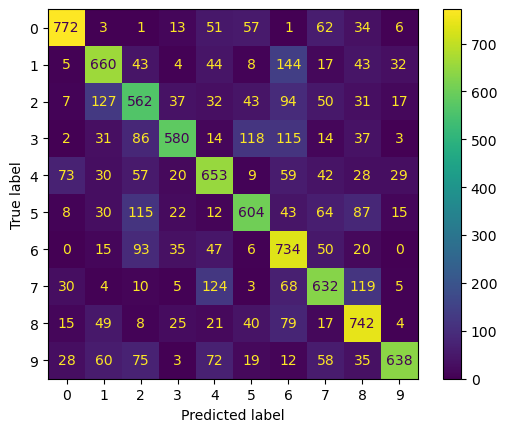

313/313 [==============================] - 0s 1ms/step
Bottle Neck Width: 100
Accuracy Score: 0.6493
Precision Score: 0.687369057336135
Recall Score: 0.6493
F1 Score: 0.6468924936116519


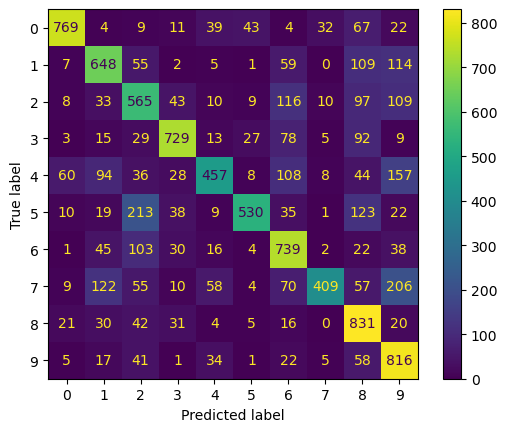

In [184]:
for i in range(50, 110, 10):    
    hp_temp_sae = HyperParameters()

    hp_temp_sae.Choice('batch_size', [64]);
    hp_temp_sae.Choice('neck_width', [i]);

    sae_temp = build_sae(hp_temp_sae)
    sae_temp.compile(optimizer='adam', loss='mean_squared_error')

    sae_temp.fit(data_train, data_train)
    encoded_temp_train = sae_temp.predict(data_train)
    encoded_temp_test = sae_temp.predict(data_test)

    hp_temp_clf = HyperParameters()

    hp_temp_clf.Choice('clf_width', [110]);
    hp_temp_clf.Choice('clf_height', [2]);
    hp_temp_clf.Choice('batch_size', [128]);
    hp_temp_clf.Choice('neck_width', [i]);

    clf_temp = build_mlp(hp_temp_clf)
    clf_temp.compile(optimizer='adam', loss='categorical_crossentropy')

    clf_temp.fit(encoded_temp_train, labels_train_hot, batch_size=32)
    predictions_temp = clf_temp.predict(encoded_temp_test)

    predictions_temp = np.argmax(predictions_temp,axis=1)

    cm_temp = confusion_matrix(labels_test, predictions_temp)
    
    print("Bottle Neck Width: " + str(i))
    
    print("Accuracy Score: " + str(accuracy_score(labels_test, predictions_temp)))
    print("Precision Score: " + str(precision_score(labels_test, predictions_temp, average='macro')))
    print("Recall Score: " + str(recall_score(labels_test, predictions_temp, average='macro')))
    print("F1 Score: " + str(f1_score(labels_test, predictions_temp, average='macro')))
    
    disp_temp = ConfusionMatrixDisplay(confusion_matrix=cm_temp)
    disp_temp.plot()
    plt.show()

### 2) SAE+Classifier [MSE Encoder, No Noise]

In [164]:
#IGNORE, here for testing
#hp_test = HyperParameters()

#hp_test.Choice('clf_width', [10]);
#hp_test.Choice('clf_height', [2]);
#hp_test.Choice('batch_size', [128]);
#hp_test.Choice('neck_width', [100]);

#test_model = build_mlp(hp_test)
#test_model.compile(optimizer='adam', loss='categorical_crossentropy')

#test_model.fit(encoded_train_data_ce, labels_train_hot, batch_size=32)

#mse_predictions = test_model.predict(encoded_test_data)

1875/1875 [==============================] - 2s 856us/step - loss: 1.5377


In [151]:
mse_predictions = best_clf.predict(encoded_test_data)

313/313 [==============================] - 0s 649us/step


In [152]:
mse_predictions = np.argmax(mse_predictions,axis=1)

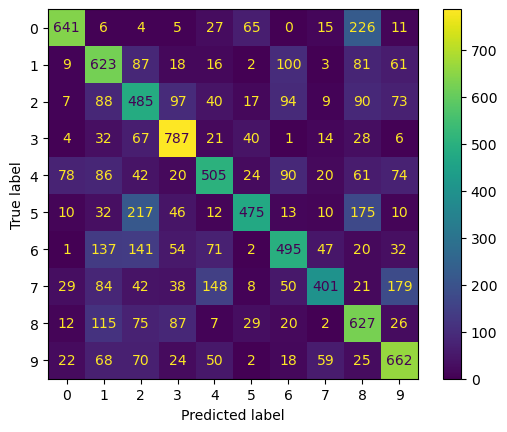

In [153]:
cm_mse = confusion_matrix(labels_test, mse_predictions)

disp_mse = ConfusionMatrixDisplay(confusion_matrix=cm_mse)
disp_mse.plot()
plt.show()

### 3) SAE+Classifier [CE Encoder, No Noise]

In [128]:
ce_predictions = best_clf_ce.predict(encoded_test_data_ce)

313/313 [==============================] - 0s 625us/step


In [129]:
ce_predictions = np.argmax(ce_predictions,axis=1)

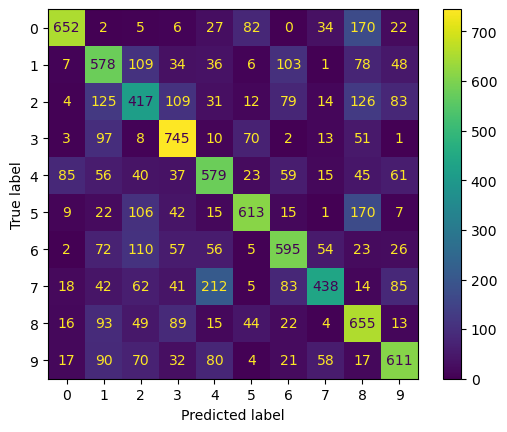

313/313 [==============================] - 0s 639us/step


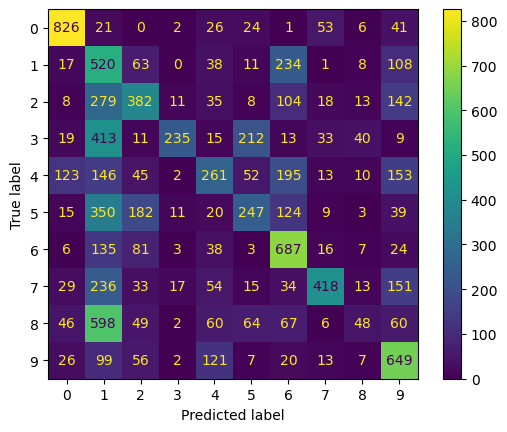

In [166]:
cm_ce = confusion_matrix(labels_test, ce_predictions)

disp_ce = ConfusionMatrixDisplay(confusion_matrix=cm_ce)
disp_ce.plot()
plt.show()

### 4) SAE+Classifier [MSE Encoder, Noise]

In [119]:
noisy_mse_predictions = best_noisy_clf.predict(noisy_encoded_test_data)

313/313 [==============================] - 0s 654us/step


In [120]:
noisy_mse_predictions = np.argmax(noisy_mse_predictions,axis=1)

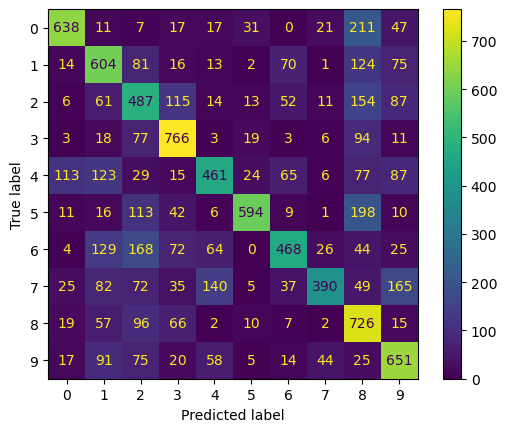

In [121]:
cm_noisy = confusion_matrix(labels_test, noisy_mse_predictions)

disp_noisy_mse = ConfusionMatrixDisplay(confusion_matrix=cm_noisy)
disp_noisy_mse.plot()
plt.show()

### 5) SAE+Classifier [CE Encoder, Noise]

In [122]:
noisy_ce_predictions = best_noisy_clf_ce.predict(noisy_encoded_test_data_ce)

313/313 [==============================] - 0s 640us/step


In [123]:
noisy_ce_predictions = np.argmax(noisy_ce_predictions,axis=1)

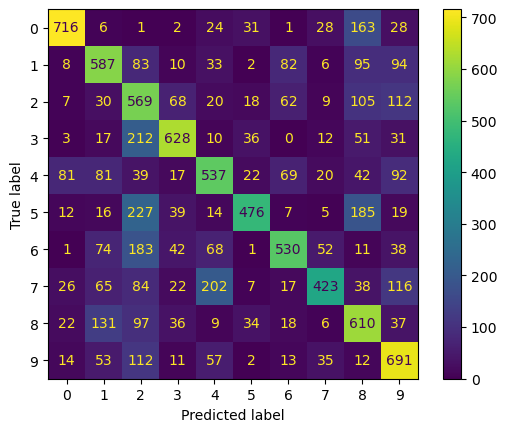

In [132]:
cm_noisy_ce = confusion_matrix(labels_test, noisy_ce_predictions)

disp_noisy_ce = ConfusionMatrixDisplay(confusion_matrix=cm_noisy_ce)
disp_noisy_ce.plot()
plt.show()

# Part 2

## For a bottleneck_width of 100...

In [16]:
# Get the codes from the Encoder 
clear_session()

neck_width = 100

enc_model = build_enc(neck_width)
dec_model = build_dec(neck_width)

sae_model = Sequential()
sae_model.add(enc_model)
sae_model.add(dec_model)



adam = Adam(learning_rate=0.001)

sae_model.compile(optimizer=adam, loss=correntropy_loss(0.5))

callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.001)

sae_model.fit(data_train, data_train,
                 batch_size=128, epochs=1, # 20
                 verbose=1, callbacks=[callback])

y_pred = sae_model.predict(data_test)

C:\Users\zainn\anaconda3\envs\eee4773\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 9s 28ms/step


In [17]:
encoder = sae_model.layers[0]


In [18]:
constellation = encoder.predict(data_train)

current_codes = constellation

1875/1875 [==============================] - 30s 16ms/step


In [19]:
ground_truths = current_codes #.mean(axis=0)
print(ground_truths.shape)

(60000, 100)


Define Loss fucntions for Encoder, and for the overall SAE

In [22]:
# First, train the encoder on the data
# So you need to set the truth for each class to be the class average from the encoding layer. 


# Define loss function for the model
def loss_function_sae():
    def loss(y_true, y_pred):
        mse_loss = tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))
        
        # IN THIS FUNCTION, we use the MSE from the bottleneck layer to calculate the cost function
        
        # Assuming y_true is the true labels and y_pred is the predicted output of the bottleneck layer
        #current_codes = sae_model.layers[0].layers[-1].output
        #distances = tensorflow.norm(current_codes - constellation_targets, axis=1)
        return mse_loss # + lambda_value * tensorflow.reduce_mean(distances)
    
    return loss

lambda_value = 0.001

def loss_function_encoder():
    def loss(y_true, y_pred):
        mse_loss = tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))
        
        return lambda_value*mse_loss # + lambda_value * tensorflow.reduce_mean(distances)
    return loss

Train the SAE using the modified cost functions...

In [23]:
from tensorflow.keras.models import Model
import pydot
import matplotlib.pyplot as plt

neck_width = 100

inputs = tensorflow.keras.layers.Input(shape=(784,))
x = Dense(units=800, activation='relu')(inputs)
x = Dense(units=200, activation='relu')(x)
bottle_neck_layer = Dense(units=neck_width, activation='relu',  name='bottleneck_layer')(x)

# start of Decoder
first_decode_layer = Dense(units=neck_width, activation='relu',  name='first_decode_layer')(x) # (bottle_neck_layer)
y = Dense(units=200, activation='relu')(first_decode_layer)
y = Dense(units=800, activation='relu')(y)
y = Dense(units=784, activation='relu',  name='model_output')(y)

model_with_outputs = Model(inputs=inputs, outputs=[bottle_neck_layer, y])

model_with_outputs.compile(optimizer=tensorflow.keras.optimizers.Adam(), 
                           loss= {'bottleneck_layer' : loss_function_encoder(), # 'mse'
                                  'model_output' : loss_function_sae()
                           }
                          )


model_with_outputs.fit(data_train, {'bottleneck_layer': ground_truths, 'model_output': data_train}, # train the encoder with ground_truths (mean of the training data), and then train full model with data_train
                  verbose=1, callbacks=[callback])

1875/1875 [==============================] - 346s 184ms/step - loss: 0.0382 - bottleneck_layer_loss: 7.7061e-05 - model_output_loss: 0.0381


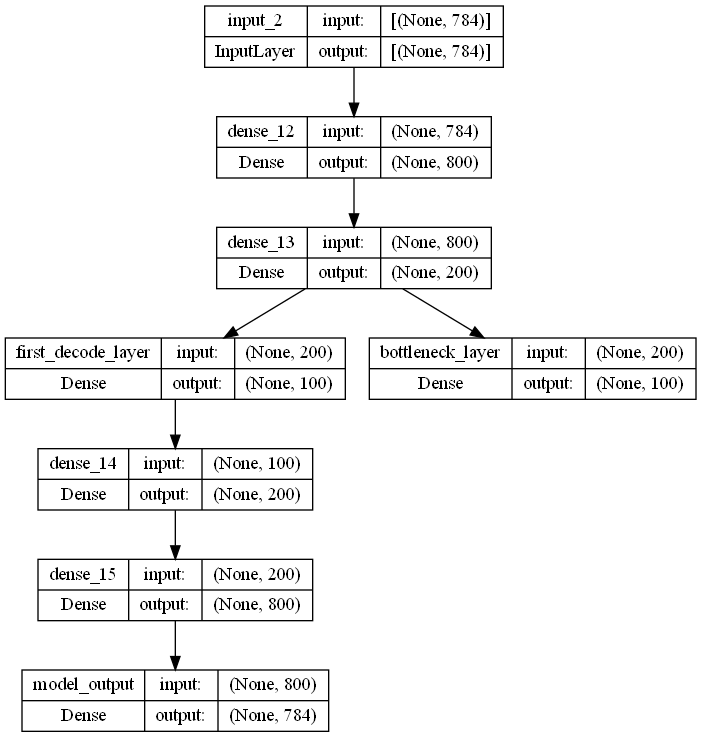

In [24]:
tensorflow.keras.utils.plot_model(model_with_outputs, show_shapes=True, show_layer_names=True)


To generate confusion matrices, first build MLP...

In [34]:
hp_temp_clf = HyperParameters()

hp_temp_clf.Choice('clf_width', [110]);
hp_temp_clf.Choice('clf_height', [2]);
hp_temp_clf.Choice('batch_size', [128]);
hp_temp_clf.Choice('neck_width', [i]);

mlp_model = build_mlp(hp_temp_clf)
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy')


In [36]:
# Predict using a specific output by name
output_name = 'model_output'

encoded_temp_train1 = model_with_outputs.predict(data_train)
encoded_temp_train1 = encoded_temp_train1[model_with_outputs.output_names.index(output_name)]

encoded_temp_test1 = model_with_outputs.predict(data_test)
encoded_temp_test1 = encoded_temp_test1[model_with_outputs.output_names.index(output_name)]


313/313 [==============================] - 7s 21ms/step


In [37]:
mlp_model.fit(encoded_temp_train1, labels_train_hot, batch_size=32)

1875/1875 [==============================] - 104s 55ms/step - loss: 1.0589


In [38]:
predictions_temp1 = mlp_model.predict(encoded_temp_test1)

predictions_temp1 = np.argmax(predictions_temp1,axis=1)

cm_temp = confusion_matrix(labels_test, predictions_temp1)

313/313 [==============================] - 2s 6ms/step


Accuracy Score: 0.6026
Precision Score: 0.6312614609204229
Recall Score: 0.6026
F1 Score: 0.6057570418866678


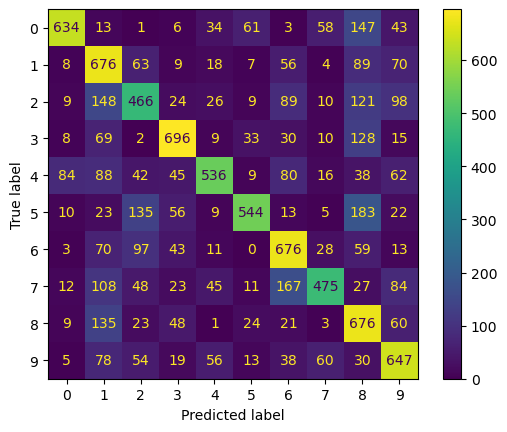

In [39]:
print("Accuracy Score: " + str(accuracy_score(labels_test, predictions_temp1)))
print("Precision Score: " + str(precision_score(labels_test, predictions_temp1, average='macro')))
print("Recall Score: " + str(recall_score(labels_test, predictions_temp1, average='macro')))
print("F1 Score: " + str(f1_score(labels_test, predictions_temp1, average='macro')))

disp_temp = ConfusionMatrixDisplay(confusion_matrix=cm_temp)
disp_temp.plot()
plt.show()

## For a neck width of 10...

In [41]:
# Get the codes from the Encoder 
clear_session()

neck_width = 10

enc_model = build_enc(neck_width)
dec_model = build_dec(neck_width)

sae_model = Sequential()
sae_model.add(enc_model)
sae_model.add(dec_model)



adam = Adam(learning_rate=0.001)

sae_model.compile(optimizer=adam, loss=correntropy_loss(0.5))

callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.001)

sae_model.fit(data_train, data_train,
                 batch_size=128, epochs=1, # 20
                 verbose=1, callbacks=[callback])

y_pred = sae_model.predict(data_test)

313/313 [==============================] - 9s 27ms/step


In [44]:
encoder_10 = sae_model.layers[0]

constellation_10 = encoder_10.predict(data_train)
current_codes_10 = constellation_10
ground_truths_10 = current_codes_10 #.mean(axis=0)
print(ground_truths_10.shape)

1875/1875 [==============================] - 27s 14ms/step
(60000, 10)


In [45]:
from tensorflow.keras.models import Model
import pydot
import matplotlib.pyplot as plt

neck_width = 10

inputs = tensorflow.keras.layers.Input(shape=(784,))
x = Dense(units=800, activation='relu')(inputs)
x = Dense(units=200, activation='relu')(x)
bottle_neck_layer = Dense(units=neck_width, activation='relu',  name='bottleneck_layer')(x)

# start of Decoder
first_decode_layer = Dense(units=neck_width, activation='relu',  name='first_decode_layer')(x) # (bottle_neck_layer)
y = Dense(units=200, activation='relu')(first_decode_layer)
y = Dense(units=800, activation='relu')(y)
y = Dense(units=784, activation='relu',  name='model_output')(y)

model_with_outputs_10 = Model(inputs=inputs, outputs=[bottle_neck_layer, y])

model_with_outputs_10.compile(optimizer=tensorflow.keras.optimizers.Adam(), 
                           loss= {'bottleneck_layer' : loss_function_encoder(), # 'mse'
                                  'model_output' : loss_function_sae()
                           }
                          )


model_with_outputs_10.fit(data_train, {'bottleneck_layer': ground_truths_10, 'model_output': data_train}, # train the encoder with ground_truths (mean of the training data), and then train full model with data_train
                  verbose=1, callbacks=[callback])

1875/1875 [==============================] - 339s 181ms/step - loss: 0.0617 - bottleneck_layer_loss: 0.0013 - model_output_loss: 0.0604


In [46]:
hp_temp_clf = HyperParameters()

hp_temp_clf.Choice('clf_width', [110]);
hp_temp_clf.Choice('clf_height', [2]);
hp_temp_clf.Choice('batch_size', [128]);
hp_temp_clf.Choice('neck_width', [i]);

mlp_model_10 = build_mlp(hp_temp_clf)
mlp_model_10.compile(optimizer='adam', loss='categorical_crossentropy')

In [49]:
# Predict using a specific output by name
output_name = 'model_output'

encoded_temp_train2 = model_with_outputs_10.predict(data_train)
encoded_temp_train2 = encoded_temp_train2[model_with_outputs_10.output_names.index(output_name)]

encoded_temp_test2 = model_with_outputs_10.predict(data_test)
encoded_temp_test2 = encoded_temp_test2[model_with_outputs_10.output_names.index(output_name)]


313/313 [==============================] - 6s 20ms/step


In [50]:
mlp_model_10.fit(encoded_temp_train2, labels_train_hot, batch_size=32)

1875/1875 [==============================] - 105s 56ms/step - loss: 0.8520


In [51]:
predictions_temp2 = mlp_model_10.predict(encoded_temp_test2)
predictions_temp2 = np.argmax(predictions_temp2,axis=1)

cm_temp = confusion_matrix(labels_test, predictions_temp2)

313/313 [==============================] - 2s 6ms/step


Accuracy Score: 0.6957
Precision Score: 0.7125167685396747
Recall Score: 0.6957000000000001
F1 Score: 0.6969288410605436


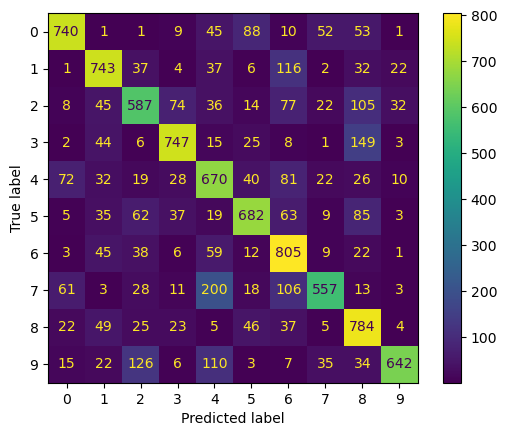

In [52]:
print("Accuracy Score: " + str(accuracy_score(labels_test, predictions_temp2)))
print("Precision Score: " + str(precision_score(labels_test, predictions_temp2, average='macro')))
print("Recall Score: " + str(recall_score(labels_test, predictions_temp2, average='macro')))
print("F1 Score: " + str(f1_score(labels_test, predictions_temp2, average='macro')))

disp_temp = ConfusionMatrixDisplay(confusion_matrix=cm_temp)
disp_temp.plot()
plt.show()

## To Validate the Selection of lambda and R in 3D space...

### Stick with a Bottle_neck size of 10, as it seems to perform better

In [54]:
def loss_function_sae1():
    def loss(y_true, y_pred):
        mse_loss = tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))
        
        # IN THIS FUNCTION, we use the MSE from the bottleneck layer to calculate the cost function
        
        # Assuming y_true is the true labels and y_pred is the predicted output of the bottleneck layer
        #current_codes = sae_model.layers[0].layers[-1].output
        #distances = tensorflow.norm(current_codes - constellation_targets, axis=1)
        return mse_loss # + lambda_value * tensorflow.reduce_mean(distances)
    
    return loss

def loss_function_encoder1(lambda_val_param):
    def loss(y_true, y_pred):
        mse_loss = tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))
        
        return lambda_val_param*mse_loss # + lambda_value * tensorflow.reduce_mean(distances)
    return loss

In [59]:
from tensorflow.keras.models import Model
import pydot
import matplotlib.pyplot as plt

neck_width = 10

inputs = tensorflow.keras.layers.Input(shape=(784,))
x = Dense(units=800, activation='relu')(inputs)
x = Dense(units=200, activation='relu')(x)
bottle_neck_layer = Dense(units=neck_width, activation='relu',  name='bottleneck_layer')(x)

# start of Decoder
first_decode_layer = Dense(units=neck_width, activation='relu',  name='first_decode_layer')(x) # (bottle_neck_layer)
y = Dense(units=200, activation='relu')(first_decode_layer)
y = Dense(units=800, activation='relu')(y)
y = Dense(units=784, activation='relu',  name='model_output')(y)

model_with_outputs_10 = Model(inputs=inputs, outputs=[bottle_neck_layer, y])

lambda_values = [0.0001, 0.005, 0.001, 0.01]

histories = []

best_loss = 100_000
best_lambda = 100_000

for lambda_value in lambda_values:
    # lambda_value will change in each iteration, and thus the model_with_outputs will fit differently each time
    print('lambda value of', lambda_value, '...')
    
    model_with_outputs_10.compile(optimizer=tensorflow.keras.optimizers.Adam(), 
                               loss= {'bottleneck_layer' : loss_function_encoder1(lambda_value), # 'mse'
                                      'model_output' : loss_function_sae1()
                               }
                              )


    history = model_with_outputs_10.fit(data_train, {'bottleneck_layer': ground_truths_10, 'model_output': data_train}, # train the encoder with ground_truths (mean of the training data), and then train full model with data_train
                      verbose=1, callbacks=[callback])
    
    print('\n')
    
    histories += [history]
    
# Identify best model
    # Check if this lambda value gives the best loss so far
    if history.history['loss'][-1] < best_loss:
        best_loss = history.history['loss'][-1]
        best_lambda = lambda_value


# Identify the best model
print('Best Lambda:', best_lambda)
print('Best Loss', best_loss)

lambda value of 0.0001 ...
1875/1875 [==============================] - 343s 183ms/step - loss: 0.0624 - bottleneck_layer_loss: 4.9785e-05 - model_output_loss: 0.0623


lambda value of 0.005 ...
1875/1875 [==============================] - 259s 138ms/step - loss: 0.0531 - bottleneck_layer_loss: 3.4910e-04 - model_output_loss: 0.0528


lambda value of 0.001 ...
1875/1875 [==============================] - 262s 140ms/step - loss: 0.0501 - bottleneck_layer_loss: 6.9538e-05 - model_output_loss: 0.0500


lambda value of 0.01 ...
1875/1875 [==============================] - 332s 177ms/step - loss: 0.0488 - bottleneck_layer_loss: 5.0437e-04 - model_output_loss: 0.0483


Best Lambda: 0.01
Best Loss 0.04880363121628761


As seen, the best Lambda turns out to be lambda = 0.01, and this corresponds to the best Loss of 0.0488036.  seen above, for lambda 0f 0.01, the bottleneck_layer_loss = 6.As9538e-5 = lambda * R, and solving for R (**when lambda = 0.01 gives a final R value = 0.0069538)**

We can use these lambda = 0.01, with a bottleneck layer of 10, to train the autoencoder and generate a final confusion matrix

Retrain a new model, given the R = 0.0069538, with bottleneck = 10, and lambda of 0.01 (this is hardcoded below)

In [62]:
model_with_outputs_10.save_weights('initial_weights.h5')

# Create a new model with the same architecture
new_model = Model(inputs=inputs, outputs=[bottle_neck_layer, y])

# Load the saved weights into the new model
new_model.load_weights('initial_weights.h5')

new_model.compile(optimizer=tensorflow.keras.optimizers.Adam(), 
                           loss= {'bottleneck_layer' : loss_function_encoder1(lambda_val_param = 0.01), # 'mse'
                                  'model_output' : loss_function_sae1()
                           }
                          )


new_model.fit(data_train, {'bottleneck_layer': ground_truths_10, 'model_output': data_train}, # train the encoder with ground_truths (mean of the training data), and then train full model with data_train
                  verbose=1, callbacks=[callback])

1875/1875 [==============================] - 292s 156ms/step - loss: 0.0475 - bottleneck_layer_loss: 3.8528e-04 - model_output_loss: 0.0472


Use the code as class assignments in the test set...

In [65]:
hp_temp_clf = HyperParameters()

hp_temp_clf.Choice('clf_width', [110]);
hp_temp_clf.Choice('clf_height', [2]);
hp_temp_clf.Choice('batch_size', [128]);
hp_temp_clf.Choice('neck_width', [i]);

mlp_model_10_val = build_mlp(hp_temp_clf)
mlp_model_10_val.compile(optimizer='adam', loss='categorical_crossentropy')

In [70]:
# Predict using a specific output by name
output_name = 'model_output'

encoded_temp_train3 = new_model.predict(data_train)
encoded_temp_train3 = encoded_temp_train3[new_model.output_names.index(output_name)]

encoded_temp_test3 = new_model.predict(data_test)
encoded_temp_test3 = encoded_temp_test3[new_model.output_names.index(output_name)]


313/313 [==============================] - 5s 17ms/step


And the new codes generated for the test set...

In [71]:
output_name = 'bottleneck_layer'
predictions_test_set = new_model.predict(data_test)
encoded_codes = predictions_test_set[new_model.output_names.index(output_name)]

print('the final codes are', encoded_codes)
print('final codes shape is', encoded_codes.shape)



313/313 [==============================] - 2s 7ms/step
the final codes are [[0.         5.083134   3.7720506  ... 0.08282513 0.         3.17954   ]
 [0.         0.80552036 5.249806   ... 4.7688813  0.         1.3493797 ]
 [0.         1.6115481  2.3445737  ... 0.75544286 0.         1.2589521 ]
 ...
 [0.         1.1726522  3.931128   ... 4.2383547  0.         1.1099576 ]
 [0.         3.4096584  2.7720132  ... 2.1496878  0.         1.6985424 ]
 [0.         5.864289   4.851036   ... 1.0132464  0.         3.2040925 ]]
final codes shape is (10000, 10)


In [72]:
mlp_model_10_val.fit(encoded_temp_train3, labels_train_hot, batch_size=32)

1875/1875 [==============================] - 73s 39ms/step - loss: 1.0714


In [98]:
predictions_temp3 = mlp_model_10.predict(encoded_temp_test3)
predictions_temp3 = np.argmax(predictions_temp3,axis=1)

cm_temp = confusion_matrix(labels_test, predictions_temp3)

313/313 [==============================] - 1s 3ms/step


Accuracy Score: 0.5982
Precision Score: 0.6157433485132054
Recall Score: 0.5982
F1 Score: 0.6009226411448547


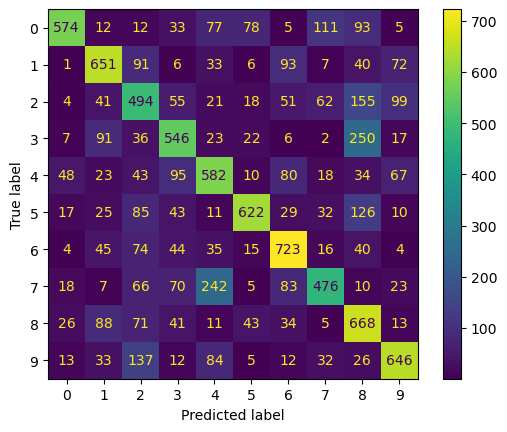

In [99]:
print("Accuracy Score: " + str(accuracy_score(labels_test, predictions_temp3)))
print("Precision Score: " + str(precision_score(labels_test, predictions_temp3, average='macro')))
print("Recall Score: " + str(recall_score(labels_test, predictions_temp3, average='macro')))
print("F1 Score: " + str(f1_score(labels_test, predictions_temp3, average='macro')))

disp_temp = ConfusionMatrixDisplay(confusion_matrix=cm_temp)
disp_temp.plot()
plt.show()